Looking at the data, we see that there was a massive shift in ridership numbers around 2020. Besides this shift, we will assume the underlying trend and seasonality component to be the same before and after 2020, ignoring the shift.

This means we will use the entire dataset to compute a seasonality component of our model, and then apply it to the trend we compute from the post shift data.

This code is splitting the data and computing the 12 month moving average:

Suppose we want to predict the revenue for the next 12 months from ticket sales for the NYC Ferry ferry system.

### Pipeline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('NYC_Ferry_Ridership.csv')
data.index = pd.DatetimeIndex(data['Date'])
data.drop('Date',axis = 1,inplace = True)
data.drop('Hour',axis = 1,inplace = True)


In [3]:
data.head()

,Route,Direction,Stop,Boardings,TypeDay
Date,,,,,
2021-07-01,RW,NB,Rockaway,20.0,Weekday
2021-07-01,RW,NB,Sunset Park/BAT,3.0,Weekday
2021-07-01,SV,SB,East 34th Street,1.0,Weekday
2021-07-01,SV,SB,East 90th St,0.0,Weekday
2021-07-01,SV,SB,Soundview,32.0,Weekday


In [4]:
boardings_per_day = data['Boardings'].groupby(data.index).sum()
boardings_per_month = boardings_per_day.resample('M').sum()
boardings_per_month = pd.DataFrame(boardings_per_month)
boardings_per_month['Month'] = boardings_per_month.index.month


boardings_per_month.loc[:,'After_2021'] = 0
boardings_per_month.loc[boardings_per_month.index >  '2021-01-01','After_2021'] = 1

#Now we split into before and after.
#Boardings_A will be before 2021-01-01, Boardings_B will be after 2021-01-01.

boardings_A = boardings_per_month.loc[boardings_per_month['After_2021'] == 0,:].copy()
boardings_B = boardings_per_month.loc[boardings_per_month['After_2021'] == 1,:].copy()





In [5]:
def set_SI(df):
    df['MA12'] = df['Boardings'].rolling(window = 12,center = True).mean()
    df['SI'] = df['Boardings']/df['MA12'] 
     

In [6]:
set_SI(boardings_A)
set_SI(boardings_B)

In [7]:
AB = pd.concat([boardings_A,boardings_B])
boardings_per_month = boardings_per_month.join(AB[['MA12','SI']],how = 'left')

In [8]:
S = boardings_per_month[['SI','Month']].groupby('Month',as_index=True).mean()

In [9]:
S.rename(columns = {'SI' : 'S'},inplace = True)

In [10]:
boardings_per_month = boardings_per_month.join(S,on = 'Month', how = 'left')

In [11]:
boardings_per_month['Deseasoned'] = boardings_per_month['Boardings']/boardings_per_month['S']

In [12]:
mask = boardings_per_month['After_2021'] == 1

In [13]:
X = np.arange(boardings_per_month['Deseasoned'][mask].values.size)
X = X.reshape(-1,1)

In [14]:
y = boardings_per_month['Deseasoned'][mask].values

In [15]:
reg = LinearRegression()

In [16]:
reg.fit(X,y)

LinearRegression()

In [17]:
b = reg.intercept_
m = reg.coef_[0]

In [18]:
boardings_per_month['X'] = 0

In [19]:
boardings_per_month.loc[mask,'X'] = X.flatten()

In [20]:
model = boardings_per_month.loc[mask,['X','Boardings']].copy()

In [21]:
model['S'] = boardings_per_month.loc[mask,'S']

In [22]:
model['T'] = model['X']*m + b

In [23]:
model['ST'] = model['T']*model['S']

In [24]:
predictions = pd.DataFrame(np.arange(model['X'].max(),model['X'].max() + 13))

In [25]:
predictions.index = pd.date_range(model.index.max(),freq = 'M',periods = 13)

In [26]:
predictions = predictions.rename(columns = {0 : 'X' })

In [27]:
predictions = predictions.drop('2023-10-31',axis = 0)

In [28]:
predictions['Month'] = predictions.index.month
predictions = predictions.join(S,on = 'Month',how = 'left')

In [29]:
predictions['T'] = predictions['X']*m + b

In [30]:
predictions['ST'] = predictions['S']*predictions['T']

In [31]:
predictions #Predictions for the next 12 months
#X is our coded time.

,X,Month,S,T,ST
2023-11-30,34,11,0.742177,643543.573825,4.776235e+05
2023-12-31,35,12,0.591643,652655.990922,3.861391e+05
2024-01-31,36,1,0.533923,661768.408020,3.533331e+05
2024-02-29,37,2,0.561283,670880.825117,3.765538e+05
2024-03-31,38,3,0.620858,679993.242214,4.221794e+05
2024-04-30,39,4,0.781502,689105.659312,5.385372e+05
2024-05-31,40,5,1.037201,698218.076409,7.241927e+05
2024-06-30,41,6,1.289639,707330.493507,9.122010e+05
2024-07-31,42,7,1.595196,716442.910604,1.142867e+06
2024-08-31,43,8,1.608437,725555.327702,1.167010e+06


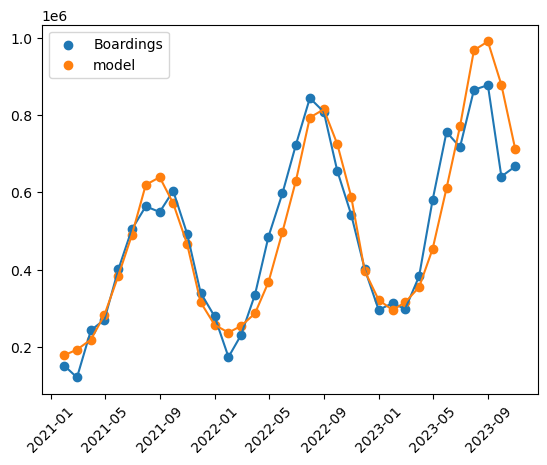

In [32]:
fig, ax = plt.subplots()

ax.scatter(model.index,model.Boardings,label = 'Boardings')
ax.plot(model.index,model.Boardings)


ax.scatter(model.index,model.ST,label = 'model')
ax.plot(model.index,model.ST)




ax.tick_params(axis='x', labelrotation=45)
ax.legend()

plt.show()

In [33]:
model_concat_predictions = pd.concat([model.ST,predictions.ST])

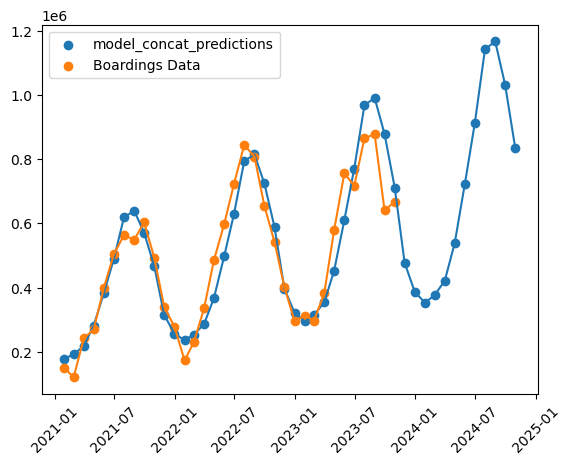

In [34]:
#Viewing our model with its predicitons.
fig, ax = plt.subplots()




ax.scatter(model_concat_predictions.index,model_concat_predictions,label = 'model_concat_predictions')
ax.plot(model_concat_predictions.index,model_concat_predictions)

ax.scatter(model.index,model.Boardings,label = 'Boardings Data')
ax.plot(model.index,model.Boardings)


ax.tick_params(axis='x', labelrotation=45)
ax.legend()

plt.show()

In [35]:
model

,X,Boardings,S,T,ST
Date,,,,,
2021-01-31,0,150695.0,0.533923,333721.392511,178181.373104
2021-02-28,1,120252.0,0.561283,342833.809609,192426.671459
2021-03-31,2,242713.0,0.620858,351946.226706,218508.736387
2021-04-30,3,269933.0,0.781502,361058.643804,282167.944551
2021-05-31,4,400295.0,1.037201,370171.060901,383941.905219
2021-06-30,5,504102.0,1.289639,379283.477999,489138.769024
2021-07-31,6,563801.0,1.595196,388395.895096,619567.621537
2021-08-31,7,549101.0,1.608437,397508.312193,639367.142564
2021-09-30,8,603836.0,1.405580,406620.729291,571537.852939


predictions = pd.Dat

In [36]:
boardings_per_month

,Boardings,Month,After_2021,MA12,SI,S,Deseasoned,X
Date,,,,,,,,
2017-07-31,470422.0,7,0,NaN,NaN,1.595196,294899.164210,0
2017-08-31,484719.0,8,0,NaN,NaN,1.608437,301360.233817,0
2017-09-30,459213.0,9,0,NaN,NaN,1.405580,326707.188334,0
2017-10-31,397407.0,10,0,NaN,NaN,1.121067,354489.845216,0
2017-11-30,244938.0,11,0,NaN,NaN,0.742177,330026.210279,0
...,...,...,...,...,...,...,...,...
2023-06-30,717197.0,6,1,NaN,NaN,1.289639,556122.290435,29
2023-07-31,865855.0,7,1,NaN,NaN,1.595196,542789.061368,30
2023-08-31,878015.0,8,1,NaN,NaN,1.608437,545880.821043,31


In [37]:
S

,S
Month,
1,0.533923
2,0.561283
3,0.620858
4,0.781502
5,1.037201
6,1.289639
7,1.595196
8,1.608437
9,1.405580


In [38]:
data.head()

,Route,Direction,Stop,Boardings,TypeDay
Date,,,,,
2021-07-01,RW,NB,Rockaway,20.0,Weekday
2021-07-01,RW,NB,Sunset Park/BAT,3.0,Weekday
2021-07-01,SV,SB,East 34th Street,1.0,Weekday
2021-07-01,SV,SB,East 90th St,0.0,Weekday
2021-07-01,SV,SB,Soundview,32.0,Weekday
